import zipline

In [1]:
from zipline.data import bundles
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

In [2]:

from zipline.data.bundles.csvdir import csvdir_equities
# Create an ingest function 
bundle_name = 'tsx'
ingest_func = csvdir_equities(['daily'], bundle_name)

# Register the data bundle and its ingest function
bundles.register(bundle_name, ingest_func);

In [3]:
from zipline.pipeline import Pipeline
from zipline.pipeline.factors import AverageDollarVolume, SimpleMovingAverage
from zipline.utils.calendars import get_calendar
from zipline.data import bundles
from zipline.pipeline.data import USEquityPricing

import os

# Set environment variable 'ZIPLINE_ROOT' to the path where the most recent data is located
os.environ['ZIPLINE_ROOT'] = "C:\\Users\\emota\\.zipline"

universe = (SimpleMovingAverage(inputs=[USEquityPricing.close], window_length=60) < 50) & (SimpleMovingAverage(inputs=[USEquityPricing.close], window_length=60) > 1)
#universe = AverageDollarVolume(window_length=120).top(500) 
trading_calendar = get_calendar('TSX') 
bundle_data = bundles.load("tsx")
# Create an empty Pipeline with the given screen
pipeline = Pipeline(screen = universe)

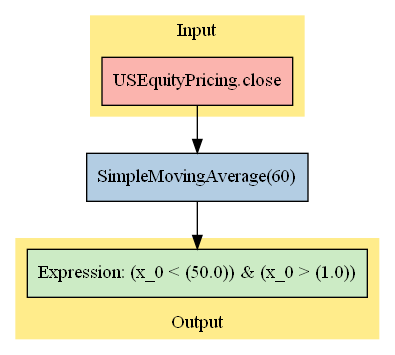

In [4]:
pipeline.show_graph(format='png')

In [5]:
import cvxpy as cvx
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 8)

In [6]:
# import resources
from zipline.pipeline.loaders import USEquityPricingLoader

# Set the dataloader
pricing_loader = USEquityPricingLoader(bundle_data.equity_daily_bar_reader, bundle_data.adjustment_reader)

from zipline.utils.calendars import get_calendar
from zipline.pipeline.data import USEquityPricing
from zipline.pipeline.engine import SimplePipelineEngine

# Define the function for the get_loader parameter
def choose_loader(column):
    if column not in USEquityPricing.columns:
        raise Exception('Column not in USEquityPricing')
    return pricing_loader

# Set the trading calendar
trading_calendar = get_calendar('TSX')

# Create a Pipeline engine
engine = SimplePipelineEngine(get_loader = choose_loader,
                              calendar = trading_calendar.all_sessions,
                              asset_finder = bundle_data.asset_finder)


In [7]:
universe_end_date = pd.Timestamp('2021-03-18', tz='UTC')

universe_tickers = engine\
    .run_pipeline(
        pipeline,
        universe_end_date,
        universe_end_date)\
    .index.get_level_values(1)\
    .values.tolist()
    
len(universe_tickers)

1201

In [8]:
from zipline.data.data_portal import DataPortal


data_portal = DataPortal(
    bundle_data.asset_finder,
    trading_calendar=trading_calendar,
    first_trading_day=bundle_data.equity_daily_bar_reader.first_trading_day,
    equity_minute_reader=None,
    equity_daily_reader=bundle_data.equity_daily_bar_reader,
    adjustment_reader=bundle_data.adjustment_reader)

In [9]:
def get_pricing(data_portal, trading_calendar, assets, start_date, end_date, field='close'):
    end_dt = pd.Timestamp(end_date.strftime('%Y-%m-%d'), tz='UTC', offset='C')
    start_dt = pd.Timestamp(start_date.strftime('%Y-%m-%d'), tz='UTC', offset='C')

    end_loc = trading_calendar.closes.index.get_loc(end_dt)
    start_loc = trading_calendar.closes.index.get_loc(start_dt)

    return data_portal.get_history_window(
        assets=assets,
        end_dt=end_dt,
        bar_count=end_loc - start_loc,
        frequency='1d',
        field=field,
        data_frequency='daily')

In [10]:
five_year_returns = \
    get_pricing(
        data_portal,
        trading_calendar,
        universe_tickers,
        universe_end_date - pd.DateOffset(years=5),
        universe_end_date)\
    .pct_change()[1:].fillna(0)

five_year_returns

,Equity(1 [AAV.TO]),Equity(2 [ABST.TO]),Equity(3 [ABX.TO]),Equity(4 [AC.TO]),Equity(5 [ACB.TO]),Equity(6 [ACD.TO]),Equity(7 [ACQ.TO]),Equity(8 [ACZ.TO]),Equity(9 [ADN.TO]),Equity(10 [AEG.TO]),...,Equity(1489 [ZWG.TO]),Equity(1490 [ZWH.TO]),Equity(1491 [ZWK.TO]),Equity(1492 [ZWP.TO]),Equity(1493 [ZWS.TO]),Equity(1494 [ZWT.TO]),Equity(1495 [ZWU.TO]),Equity(1496 [ZXM.TO]),Equity(1497 [ZZZ.TO]),Equity(1498 [ZZZD.TO])
2016-03-22 00:00:00+00:00,-0.006941,0.007639,-0.015649,-0.022928,0.000000,0.000000,0.007648,0.000000,-0.010443,0.000000,...,0.000000,-0.005735,0.000000,0.000000,0.000000,0.000000,0.006006,0.006286,0.005191,0.000000
2016-03-23 00:00:00+00:00,-0.025820,-0.018306,-0.072429,-0.031177,0.000000,0.001063,-0.035615,-0.000997,0.006332,0.000000,...,0.000000,0.010481,0.000000,0.000000,0.000000,0.000000,-0.005237,0.004922,-0.026935,0.000000
2016-03-24 00:00:00+00:00,-0.004247,0.001507,0.023911,-0.015110,0.000000,0.000000,0.054487,-0.004991,0.000000,0.000000,...,0.000000,0.002088,0.000000,0.000000,0.000000,0.000000,0.000737,0.001742,-0.013328,0.000000
2016-03-28 00:00:00+00:00,0.008824,0.001693,0.000585,0.003513,0.000000,0.015399,-0.003445,0.000000,0.021407,-0.006270,...,0.000000,-0.007225,0.000000,0.000000,0.000000,0.000000,0.002104,0.003197,0.023226,0.000000
2016-03-29 00:00:00+00:00,-0.007434,-0.015584,0.021701,0.025674,0.000000,0.000000,-0.014979,0.004639,0.008851,0.000000,...,0.000000,-0.001609,0.000000,0.000000,0.000000,0.000000,0.003780,0.003515,-0.006869,0.000000
2016-03-30 00:00:00+00:00,0.045528,-0.011062,-0.029427,0.006940,0.000000,0.001177,0.012282,0.000000,0.015441,0.000000,...,0.000000,-0.005186,0.000000,0.000000,0.000000,0.000000,0.003766,0.005744,0.036690,0.000000
2016-03-31 00:00:00+00:00,0.001545,0.001543,-0.010087,0.012429,0.000000,0.009663,0.052578,0.000000,0.022740,0.000000,...,0.000000,0.000493,0.000000,0.000000,0.000000,0.000000,0.004481,-0.004829,0.000522,0.000000
2016-04-01 00:00:00+00:00,-0.051893,-0.001541,0.007925,-0.012277,0.000000,-0.005303,-0.002196,-0.003994,-0.014868,0.000000,...,0.000000,0.003169,0.000000,0.000000,0.000000,0.000000,-0.003009,-0.007511,-0.002088,0.000000
2016-04-04 00:00:00+00:00,-0.014941,0.000000,-0.007863,-0.042938,0.000000,-0.001170,-0.012653,0.000000,0.004528,-0.041325,...,0.000000,0.006809,0.000000,0.000000,0.000000,0.000000,-0.003018,0.000893,-0.020513,0.000000
2016-04-05 00:00:00+00:00,0.012014,-0.014272,0.046478,-0.029516,0.000000,0.011846,0.001672,0.000000,-0.010449,-0.012833,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.009707,-0.016015,-0.003144,0.000000


In [11]:
from sklearn.decomposition import PCA


def fit_pca(returns, num_factor_exposures, svd_solver):
    """
    Fit PCA model with returns.

    Parameters
    ----------
    returns : DataFrame
        Returns for each ticker and date
    num_factor_exposures : int
        Number of factors for PCA
    svd_solver: str
        The solver to use for the PCA model

    Returns
    -------
    pca : PCA
        Model fit to returns
    """
    
    pca = PCA(n_components=num_factor_exposures, svd_solver=svd_solver)
    pca.fit(returns)
    
    return pca

In [12]:
num_factor_exposures = 20
pca = fit_pca(five_year_returns, num_factor_exposures, 'full')

pca.components_

array([[ 3.23449868e-03,  1.99847466e-04, -1.00560741e-05, ...,
         2.35712287e-03,  1.42544582e-03,  8.11960349e-04],
       [-5.93040191e-02, -1.78580976e-02, -1.35211510e-02, ...,
        -2.18012386e-02, -3.26470734e-02, -1.41927651e-02],
       [-6.26926397e-03, -2.56601219e-03, -3.53118169e-03, ...,
        -1.44176395e-03, -2.18618931e-03, -1.74897460e-03],
       ...,
       [-1.61206313e-03, -3.77034746e-03,  7.39944324e-03, ...,
        -4.01478509e-03,  2.28661937e-03,  3.29996025e-03],
       [-6.49810553e-02, -7.79683714e-03, -3.51768577e-03, ...,
         2.00533464e-03, -2.33709939e-02, -2.18024115e-03],
       [-4.47131575e-02, -2.92646574e-02,  2.19249982e-03, ...,
        -2.59541768e-03, -1.72118655e-02, -1.09448938e-02]])

<BarContainer object of 20 artists>

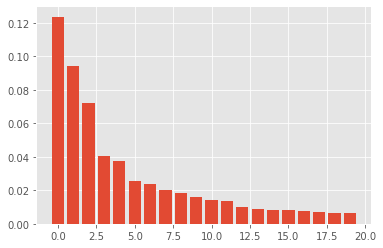

In [13]:
plt.bar(np.arange(num_factor_exposures), pca.explained_variance_ratio_)

In [14]:
def factor_betas(pca, factor_beta_indices, factor_beta_columns):
    """
    Get the factor betas from the PCA model.

    Parameters
    ----------
    pca : PCA
        Model fit to returns
    factor_beta_indices : 1 dimensional Ndarray
        Factor beta indices
    factor_beta_columns : 1 dimensional Ndarray
        Factor beta columns

    Returns
    -------
    factor_betas : DataFrame
        Factor betas
    """
    assert len(factor_beta_indices.shape) == 1
    assert len(factor_beta_columns.shape) == 1

    return pd.DataFrame(pca.components_.T, factor_beta_indices, factor_beta_columns)

In [15]:
risk_model = {}
risk_model['factor_betas'] = factor_betas(pca, five_year_returns.columns.values, np.arange(num_factor_exposures))

risk_model['factor_betas']

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Equity(1 [AAV.TO]),3.234499e-03,-0.059304,-0.006269,-0.021957,0.006308,-0.001281,-0.008043,0.008429,-0.043091,0.050340,-0.019063,-0.006386,0.007420,-0.029190,0.026122,-0.032339,-0.011587,-0.001612,-0.064981,-0.044713
Equity(2 [ABST.TO]),1.998475e-04,-0.017858,-0.002566,0.004199,-0.002344,-0.004425,-0.000585,-0.003369,0.007498,-0.009284,0.000441,0.006759,-0.004350,-0.019431,0.018632,-0.005210,-0.015788,-0.003770,-0.007797,-0.029265
Equity(3 [ABX.TO]),-1.005607e-05,-0.013521,-0.003531,0.093123,0.011699,-0.020305,-0.004244,-0.002266,-0.007165,0.002942,-0.011635,0.001586,-0.006923,-0.005723,-0.001279,0.009733,0.012619,0.007399,-0.003518,0.002192
Equity(4 [AC.TO]),3.114369e-03,-0.051942,-0.004500,-0.026516,-0.008158,-0.000685,0.005414,-0.002877,-0.002978,-0.024885,0.013198,0.006113,-0.018075,0.033452,-0.042506,0.025019,0.017784,-0.013490,-0.007906,0.018093
Equity(5 [ACB.TO]),4.319824e-03,-0.059570,-0.004553,0.001906,-0.022896,0.031307,0.006199,-0.041696,0.142619,0.019743,-0.056516,-0.300189,-0.021213,0.050213,-0.042066,-0.054282,0.092003,0.143910,-0.059205,0.032787
Equity(6 [ACD.TO]),1.140425e-03,-0.017721,0.000326,-0.000573,-0.001606,-0.000415,-0.003379,-0.002159,0.002672,-0.009211,0.001662,0.001027,-0.017939,0.008979,0.024166,0.041549,-0.000136,0.012927,-0.033413,-0.028333
Equity(7 [ACQ.TO]),3.667532e-03,-0.043929,-0.003717,-0.023578,-0.011150,0.000564,0.004361,-0.004968,0.004738,-0.019670,0.016061,0.005056,0.006945,-0.009522,-0.002135,-0.024061,0.021327,0.044647,-0.021329,0.027548
Equity(8 [ACZ.TO]),1.576793e-03,-0.011785,-0.001016,-0.002295,-0.001781,-0.000594,-0.002222,-0.001983,0.004700,-0.012926,0.003262,0.006261,-0.004099,-0.001048,0.000765,0.004293,0.000228,0.003066,-0.003686,0.000806
Equity(9 [ADN.TO]),2.310512e-03,-0.020961,0.002204,-0.002938,-0.001829,0.003208,-0.000420,-0.001884,0.004604,-0.021868,0.004300,0.007291,-0.010442,-0.000680,0.012204,0.009094,0.000089,0.000332,0.000055,0.001366
Equity(10 [AEG.TO]),8.629469e-04,-0.033951,-0.004773,-0.009057,-0.003039,0.000123,0.000711,-0.012736,0.037212,-0.007159,0.004518,0.013764,-0.011258,-0.040667,-0.004667,-0.004271,0.006312,0.026114,-0.038594,-0.021329


In [16]:
def factor_returns(pca, returns, factor_return_indices, factor_return_columns):
    """
    Get the factor returns from the PCA model.

    Parameters
    ----------
    pca : PCA
        Model fit to returns
    returns : DataFrame
        Returns for each ticker and date
    factor_return_indices : 1 dimensional Ndarray
        Factor return indices
    factor_return_columns : 1 dimensional Ndarray
        Factor return columns

    Returns
    -------
    factor_returns : DataFrame
        Factor returns
    """
    assert len(factor_return_indices.shape) == 1
    assert len(factor_return_columns.shape) == 1
    
    return pd.DataFrame(pca.transform(returns), factor_return_indices, factor_return_columns)

<AxesSubplot:>

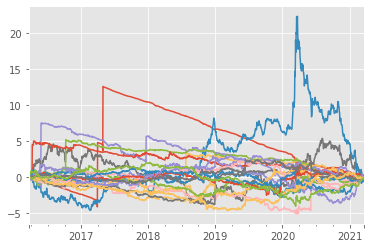

In [17]:
risk_model['factor_returns'] = factor_returns(
    pca,
    five_year_returns,
    five_year_returns.index,
    np.arange(num_factor_exposures))

risk_model['factor_returns'].cumsum().plot(legend=None)

In [18]:
def factor_cov_matrix(factor_returns, ann_factor):
    """
    Get the factor covariance matrix

    Parameters
    ----------
    factor_returns : DataFrame
        Factor returns
    ann_factor : int
        Annualization factor

    Returns
    -------
    factor_cov_matrix : 2 dimensional Ndarray
        Factor covariance matrix
    """
    
    return np.diag(factor_returns.var(axis=0, ddof=1)*ann_factor)

In [19]:
ann_factor = 252
risk_model['factor_cov_matrix'] = factor_cov_matrix(risk_model['factor_returns'], ann_factor)

risk_model['factor_cov_matrix']

array([[33.00622429,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        , 25.18829358,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        , 19.30892004,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , 10.75785991,  0.        ,
         0.        ,  0.        ,  0.        ,  

In [20]:
def idiosyncratic_var_matrix(returns, factor_returns, factor_betas, ann_factor):
    """
    Get the idiosyncratic variance matrix

    Parameters
    ----------
    returns : DataFrame
        Returns for each ticker and date
    factor_returns : DataFrame
        Factor returns
    factor_betas : DataFrame
        Factor betas
    ann_factor : int
        Annualization factor

    Returns
    -------
    idiosyncratic_var_matrix : DataFrame
        Idiosyncratic variance matrix
    """
    
    common_returns_ = pd.DataFrame(np.dot(factor_returns, factor_betas.T), returns.index, returns.columns)
    
    residuals_ = (returns - common_returns_)
    
    return pd.DataFrame(np.diag(np.var(residuals_))*ann_factor, returns.columns, returns.columns)

In [21]:
risk_model['idiosyncratic_var_matrix'] = idiosyncratic_var_matrix(five_year_returns, risk_model['factor_returns'], risk_model['factor_betas'], ann_factor)

risk_model['idiosyncratic_var_matrix']

,Equity(1 [AAV.TO]),Equity(2 [ABST.TO]),Equity(3 [ABX.TO]),Equity(4 [AC.TO]),Equity(5 [ACB.TO]),Equity(6 [ACD.TO]),Equity(7 [ACQ.TO]),Equity(8 [ACZ.TO]),Equity(9 [ADN.TO]),Equity(10 [AEG.TO]),...,Equity(1489 [ZWG.TO]),Equity(1490 [ZWH.TO]),Equity(1491 [ZWK.TO]),Equity(1492 [ZWP.TO]),Equity(1493 [ZWS.TO]),Equity(1494 [ZWT.TO]),Equity(1495 [ZWU.TO]),Equity(1496 [ZXM.TO]),Equity(1497 [ZZZ.TO]),Equity(1498 [ZZZD.TO])
Equity(1 [AAV.TO]),0.163148,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000
Equity(2 [ABST.TO]),0.000000,0.075918,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000
Equity(3 [ABX.TO]),0.000000,0.000000,0.045599,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000
Equity(4 [AC.TO]),0.000000,0.000000,0.000000,0.145765,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000
Equity(5 [ACB.TO]),0.000000,0.000000,0.000000,0.000000,0.324421,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000
Equity(6 [ACD.TO]),0.000000,0.000000,0.000000,0.000000,0.000000,0.073334,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000
Equity(7 [ACQ.TO]),0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.225749,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000
Equity(8 [ACZ.TO]),0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.017272,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000
Equity(9 [ADN.TO]),0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.041923,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000
Equity(10 [AEG.TO]),0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.521537,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000


In [22]:
def idiosyncratic_var_vector(returns, idiosyncratic_var_matrix):
    """
    Get the idiosyncratic variance vector

    Parameters
    ----------
    returns : DataFrame
        Returns for each ticker and date
    idiosyncratic_var_matrix : DataFrame
        Idiosyncratic variance matrix

    Returns
    -------
    idiosyncratic_var_vector : DataFrame
        Idiosyncratic variance Vector
    """
    
    
    
    return pd.DataFrame(data=np.diag(idiosyncratic_var_matrix.values), index=returns.columns)

In [23]:
risk_model['idiosyncratic_var_vector'] = idiosyncratic_var_vector(five_year_returns, risk_model['idiosyncratic_var_matrix'])

risk_model['idiosyncratic_var_vector']

,0
Equity(1 [AAV.TO]),0.163148
Equity(2 [ABST.TO]),0.075918
Equity(3 [ABX.TO]),0.045599
Equity(4 [AC.TO]),0.145765
Equity(5 [ACB.TO]),0.324421
Equity(6 [ACD.TO]),0.073334
Equity(7 [ACQ.TO]),0.225749
Equity(8 [ACZ.TO]),0.017272
Equity(9 [ADN.TO]),0.041923
Equity(10 [AEG.TO]),0.521537


In [24]:
def predict_portfolio_risk(factor_betas, factor_cov_matrix, idiosyncratic_var_matrix, weights):
    """
    Get the predicted portfolio risk
    
    Formula for predicted portfolio risk is sqrt(X.T(BFB.T + S)X) where:
      X is the portfolio weights
      B is the factor betas
      F is the factor covariance matrix
      S is the idiosyncratic variance matrix

    Parameters
    ----------
    factor_betas : DataFrame
        Factor betas
    factor_cov_matrix : 2 dimensional Ndarray
        Factor covariance matrix
    idiosyncratic_var_matrix : DataFrame
        Idiosyncratic variance matrix
    weights : DataFrame
        Portfolio weights

    Returns
    -------
    predicted_portfolio_risk : float
        Predicted portfolio risk
    """
    assert len(factor_cov_matrix.shape) == 2
    
    X = weights
    B = factor_betas
    F = factor_cov_matrix
    S = idiosyncratic_var_matrix
     
    return np.sqrt(X.T.dot(B.dot(F).dot(B.T) + S).dot(X))[0][0]

In [25]:
all_weights = pd.DataFrame(np.repeat(1/len(universe_tickers), len(universe_tickers)), universe_tickers)

predict_portfolio_risk(
    risk_model['factor_betas'],
    risk_model['factor_cov_matrix'],
    risk_model['idiosyncratic_var_matrix'],
    all_weights)

0.1043599023998343

In [26]:
from zipline.pipeline.factors import Returns

def momentum_1yr(window_length, universe, sector):
    return Returns(window_length=window_length, mask=universe) \
        .demean(groupby=sector) \
        .rank() \
        .zscore()

In [27]:
def mean_reversion_5day_sector_neutral(window_length, universe, sector):
    """
    Generate the mean reversion 5 day sector neutral factor

    Parameters
    ----------
    window_length : int
        Returns window length
    universe : Zipline Filter
        Universe of stocks filter
    sector : Zipline Classifier
        Sector classifier

    Returns
    -------
    factor : Zipline Factor
        Mean reversion 5 day sector neutral factor
    """

    return (
            Returns(window_length=window_length, mask=universe).
            demean(groupby=sector). #we use the custom Sector class that we reviewed earlier
            rank().
            zscore() * -1
        )

In [28]:
from zipline.pipeline.classifiers import Classifier
from zipline.utils.numpy_utils import int64_dtype

class Sector(Classifier):
    inputs = ()
    dtype = int64_dtype
    window_length = 0
    missing_value = -1

    def __init__(self):
        create_sid_table_from_file()
        self.data = np.load("tsx_sids.npy")

    def _compute(self, arrays, dates, assets, mask):
        return np.where(
            mask,
            self.data[assets],
            self.missing_value,
        )

In [29]:
len(universe_tickers)

1201

In [30]:
factor_start_date = universe_end_date - pd.DateOffset(years=2, days=3)

In [31]:
window_length = 5

In [32]:
def get_tickers_from_bundle(bundle_name):
    """Gets a list of tickers from a given bundle"""
    bundle_data = bundles.load(bundle_name, os.environ, None)

    # get a list of all sids
    lifetimes = bundle_data.asset_finder._compute_asset_lifetimes()
    all_sids = lifetimes.sid

    # retreive all assets in the bundle
    all_assets = bundle_data.asset_finder.retrieve_all(all_sids)

    # return only tickers
    return dict(map(lambda x: (x.symbol, x.sid), all_assets))

def create_sid_table_from_file(bundle_name='tsx'):
    """reads the raw file, maps tickers -> SIDS,
    then maps sector strings to integers, and saves
    to the file: SID_FILE"""
    df = pd.read_csv("C:\\Users\\emota\\Documents\\Trading\\symbols_sectors.csv", index_col="symbol")
    df = df.drop_duplicates()

    coded_sectors_for_ticker = df.sector_id

    ae_d = get_tickers_from_bundle(bundle_name)
    N = max(ae_d.values()) + 1

    # create empty 1-D array to hold data where index = SID
    sectors = np.full(N, -1, np.dtype('int64'))

    # iterate over Assets in the bundle, and fill in sectors
    for ticker, sid in ae_d.items():
        sectors[sid] = coded_sectors_for_ticker.get(ticker, -1)

    np.save("tsx_sids.npy", sectors)
    
create_sid_table_from_file()

In [33]:
pipeline = Pipeline(screen=universe)
pipeline.add(
    mean_reversion_5day_sector_neutral(window_length, universe, Sector()),
    'Mean_Reversion_5Day_Sector_Neutral')

engine.run_pipeline(pipeline, factor_start_date, universe_end_date)

Mean_Reversion_5Day_Sector_Neutral
2019-03-15 00:00:00+00:00 Equity(1 [AAV.TO])                                1.581139
                          Equity(2 [ABST.TO])                               1.264911
                          Equity(3 [ABX.TO])                                0.948683
                          Equity(4 [AC.TO])                                 0.632456
                          Equity(6 [ACD.TO])                                     NaN
                          Equity(7 [ACQ.TO])                                0.316228
                          Equity(8 [ACZ.TO])                               -0.000000
                          Equity(9 [ADN.TO])                                     NaN
                          Equity(10 [AEG.TO])                                    NaN
                          Equity(12 [AEZS.TO])                                   NaN
                          Equity(13 [AFN.TO])                                    NaN
                          Equity(14 [AGI.TO])                                    NaN
                          Equity(15 [AH.TO])                                     NaN
                          Equity(17 [AI.TO])                                     NaN
                          Equity(18 [AIF.TO])                              -0.316228
                          Equity(20 [AIM.TO])                                    NaN
                          Equity(22 [AKU.TO])                                    NaN
                          Equity(23 [ALA.TO])                              -0.632456
                          Equity(24 [ALB.TO])                                    NaN
                          Equity(25 [ALC.TO])                                    NaN
                          Equity(27 [ALS.TO])                                    NaN
                          Equity(28 [ALYA.TO])                                   NaN
                          Equity(32 [AOI.TO])                                    NaN
                          Equity(33 [AOT.TO])                                    NaN
                          Equity(34 [APHA.TO])                                   NaN
                          Equity(36 [APS.TO])                                    NaN
                          Equity(37 [APY.TO])                                    NaN
                          Equity(39 [AQN.TO])                                    NaN
                          Equity(40 [AR.TO])                                     NaN
                          Equity(42 [ARE.TO])                                    NaN
...                                                                              ...
2021-03-18 00:00:00+00:00 Equity(1463 [ZPR.TO])                                  NaN
                          Equity(1464 [ZPS.TO])                                  NaN
                          Equity(1465 [ZPW.TO])                                  NaN
                          Equity(1466 [ZQB.TO])                                  NaN
                          Equity(1468 [ZRE.TO])                                  NaN
                          Equity(1469 [ZRR.TO])                                  NaN
                          Equity(1471 [ZSML.TO])                                 NaN
                          Equity(1474 [ZSU.TO])                                  NaN
                          Equity(1475 [ZTIP.TO])                                 NaN
                          Equity(1476 [ZUB.TO])                                  NaN
                          Equity(1477 [ZUD.TO])                                  NaN
                          Equity(1480 [ZUP.TO])                                  NaN
                          Equity(1481 [ZUQ.TO])                                  NaN
                          Equity(1482 [ZUT.TO])                                  NaN
                          Equity(1483 [ZVC.TO])                                  NaN
                          Equity(1484 [ZVU.TO])        

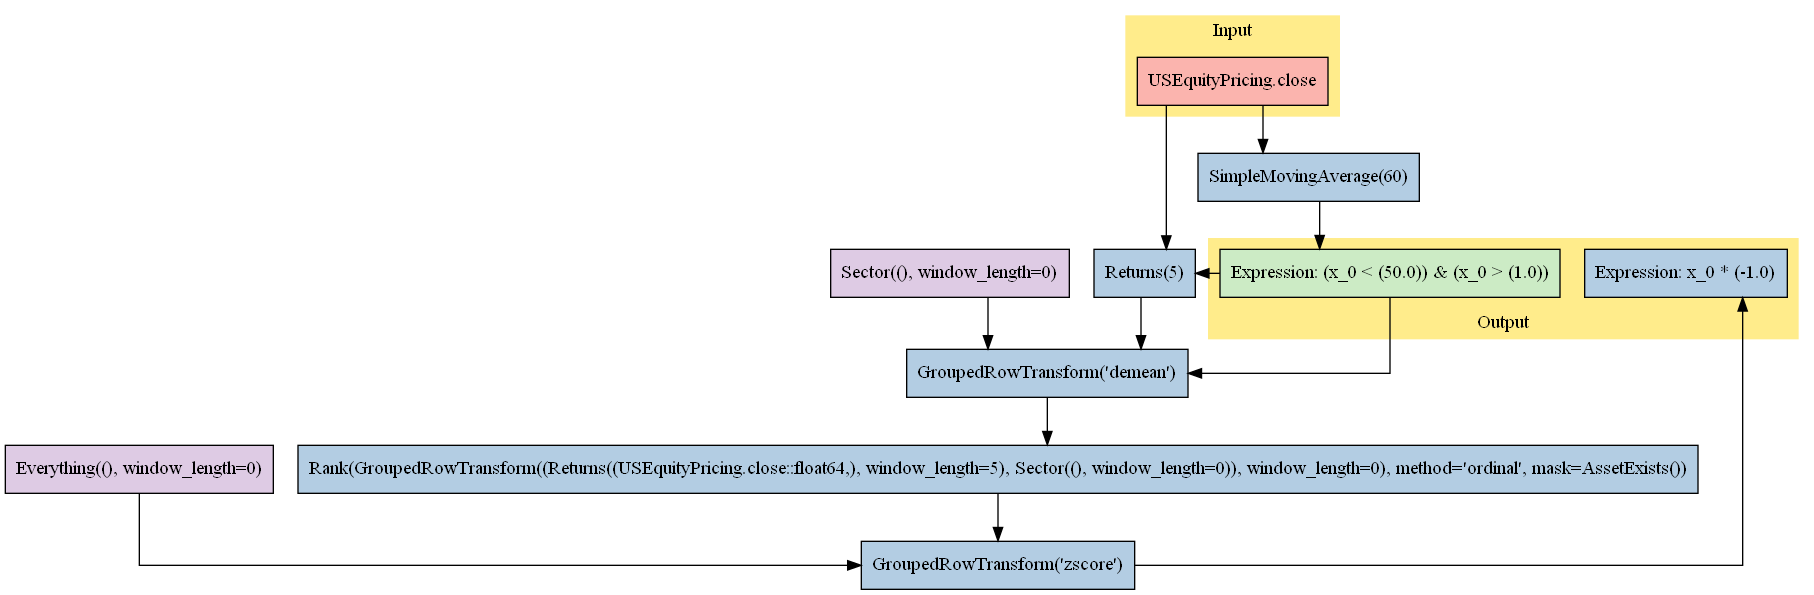

In [34]:
pipeline.show_graph(format='png')

In [35]:
from zipline.pipeline.factors import SimpleMovingAverage

def mean_reversion_5day_sector_neutral_smoothed(window_length, universe, sector):
    """
    Generate the mean reversion 5 day sector neutral smoothed factor

    Parameters
    ----------
    window_length : int
        Returns window length
    universe : Zipline Filter
        Universe of stocks filter
    sector : Zipline Classifier
        Sector classifier

    Returns
    -------
    factor : Zipline Factor
        Mean reversion 5 day sector neutral smoothed factor
    """

    data = mean_reversion_5day_sector_neutral(window_length, universe, sector)

    factor_smoothed = (
        SimpleMovingAverage(inputs=[data], window_length=window_length).
        rank().
        zscore()
    )

    return factor_smoothed


In [36]:
pipeline = Pipeline(screen=universe)
pipeline.add(
    mean_reversion_5day_sector_neutral_smoothed(5, universe, Sector()),
    'Mean_Reversion_5Day_Sector_Neutral_Smoothed')
engine.run_pipeline(pipeline, factor_start_date, universe_end_date)

Mean_Reversion_5Day_Sector_Neutral_Smoothed
2019-03-15 00:00:00+00:00 Equity(1 [AAV.TO])                                         1.581139
                          Equity(2 [ABST.TO])                                        1.264911
                          Equity(3 [ABX.TO])                                         0.948683
                          Equity(4 [AC.TO])                                          0.632456
                          Equity(6 [ACD.TO])                                              NaN
                          Equity(7 [ACQ.TO])                                         0.316228
                          Equity(8 [ACZ.TO])                                         0.000000
                          Equity(9 [ADN.TO])                                              NaN
                          Equity(10 [AEG.TO])                                             NaN
                          Equity(12 [AEZS.TO])                                            NaN
                          Equity(13 [AFN.TO])                                             NaN
                          Equity(14 [AGI.TO])                                             NaN
                          Equity(15 [AH.TO])                                              NaN
                          Equity(17 [AI.TO])                                              NaN
                          Equity(18 [AIF.TO])                                       -0.316228
                          Equity(20 [AIM.TO])                                             NaN
                          Equity(22 [AKU.TO])                                             NaN
                          Equity(23 [ALA.TO])                                       -0.632456
                          Equity(24 [ALB.TO])                                             NaN
                          Equity(25 [ALC.TO])                                             NaN
                          Equity(27 [ALS.TO])                                             NaN
                          Equity(28 [ALYA.TO])                                            NaN
                          Equity(32 [AOI.TO])                                             NaN
                          Equity(33 [AOT.TO])                                             NaN
                          Equity(34 [APHA.TO])                                            NaN
                          Equity(36 [APS.TO])                                             NaN
                          Equity(37 [APY.TO])                                             NaN
                          Equity(39 [AQN.TO])                                             NaN
                          Equity(40 [AR.TO])                                              NaN
                          Equity(42 [ARE.TO])                                             NaN
...                                                                                       ...
2021-03-18 00:00:00+00:00 Equity(1463 [ZPR.TO])                                           NaN
                          Equity(1464 [ZPS.TO])                                           NaN
                          Equity(1465 [ZPW.TO])                                           NaN
                          Equity(1466 [ZQB.TO])                                           NaN
                          Equity(1468 [ZRE.TO])                                           NaN
                          Equity(1469 [ZRR.TO])                                           NaN
                          Equity(1471 [ZSML.TO])                                          NaN
                          Equity(1474 [ZSU.TO])                                           NaN
                          Equity(1475 [ZTIP.TO])                                          NaN
                          Equity(1476 [ZUB.TO])                                           NaN
                          Equity(1477 [ZUD.TO])                                           NaN
        

In [37]:
from zipline.pipeline.data import USEquityPricing


class CTO(Returns):
    """
    Computes the overnight return, per hypothesis from
    https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2554010
    """
    inputs = [USEquityPricing.open, USEquityPricing.close]
    
    def compute(self, today, assets, out, opens, closes):
        """
        The opens and closes matrix is 2 rows x N assets, with the most recent at the bottom.
        As such, opens[-1] is the most recent open, and closes[0] is the earlier close
        """
        out[:] = (opens[-1] - closes[0]) / closes[0]

        
class TrailingOvernightReturns(Returns):
    """
    Sum of trailing 1m O/N returns
    """
    window_safe = True
    
    def compute(self, today, asset_ids, out, cto):
        out[:] = np.nansum(cto, axis=0)

        
def overnight_sentiment(cto_window_length, trail_overnight_returns_window_length, universe):
    cto_out = CTO(mask=universe, window_length=cto_window_length)
    return TrailingOvernightReturns(inputs=[cto_out], window_length=trail_overnight_returns_window_length) \
        .rank() \
        .zscore()

In [38]:
def overnight_sentiment_smoothed(cto_window_length, trail_overnight_returns_window_length, universe):
    unsmoothed_factor = overnight_sentiment(cto_window_length, trail_overnight_returns_window_length, universe)
    return SimpleMovingAverage(inputs=[unsmoothed_factor], window_length=trail_overnight_returns_window_length) \
        .rank() \
        .zscore()

In [39]:
#universe = AverageDollarVolume(window_length=120).top(500)
sector = Sector()

pipeline = Pipeline(screen=universe)
pipeline.add(
    momentum_1yr(252, universe, sector),
    'Momentum_1YR')
pipeline.add(
    mean_reversion_5day_sector_neutral(5, universe, sector),
    'Mean_Reversion_5Day_Sector_Neutral')
pipeline.add(
    mean_reversion_5day_sector_neutral_smoothed(5, universe, sector),
    'Mean_Reversion_5Day_Sector_Neutral_Smoothed')
pipeline.add(
    overnight_sentiment(2, 5, universe),
    'Overnight_Sentiment')
pipeline.add(
    overnight_sentiment_smoothed(2, 5, universe),
    'Overnight_Sentiment_Smoothed')
all_factors = engine.run_pipeline(pipeline, factor_start_date, universe_end_date)

all_factors.head()

Mean_Reversion_5Day_Sector_Neutral  \
2019-03-15 00:00:00+00:00 Equity(1 [AAV.TO])                             1.581139   
                          Equity(2 [ABST.TO])                            1.264911   
                          Equity(3 [ABX.TO])                             0.948683   
                          Equity(4 [AC.TO])                              0.632456   
                          Equity(6 [ACD.TO])                                  NaN   

                                               Mean_Reversion_5Day_Sector_Neutral_Smoothed  \
2019-03-15 00:00:00+00:00 Equity(1 [AAV.TO])                                      1.581139   
                          Equity(2 [ABST.TO])                                     1.264911   
                          Equity(3 [ABX.TO])                                      0.948683   
                          Equity(4 [AC.TO])                                       0.632456   
                          Equity(6 [ACD.TO])                                           NaN   

                                               Momentum_1YR  \
2019-03-15 00:00:00+00:00 Equity(1 [AAV.TO])      -1.566699   
                          Equity(2 [ABST.TO])     -1.218544   
                          Equity(3 [ABX.TO])      -0.870388   
                          Equity(4 [AC.TO])       -0.522233   
                          Equity(6 [ACD.TO])            NaN   

                                               Overnight_Sentiment  \
2019-03-15 00:00:00+00:00 Equity(1 [AAV.TO])             -1.088365   
                          Equity(2 [ABST.TO])            -0.844066   
                          Equity(3 [ABX.TO])              1.568728   
                          Equity(4 [AC.TO])              -1.598922   
                          Equity(6 [ACD.TO])             -1.456186   

                                               Overnight_Sentiment_Smoothed  
2019-03-15 00:00:00+00:00 Equity(1 [AAV.TO])                      -1.527554  
                          Equity(2 [ABST.TO])                     -1.187183  
                          Equity(3 [ABX.TO])                       1.535789  
                          Equity(4 [AC.TO])                       -1.651076  
                          Equity(6 [ACD.TO])                      -1.612647

In [40]:
import alphalens as al

assets = all_factors.index.levels[1].values.tolist()
pricing = get_pricing(
    data_portal,
    trading_calendar,
    assets,
    factor_start_date,
    universe_end_date)

In [47]:
clean_factor_data = {
    factor: al.utils.get_clean_factor_and_forward_returns(factor=factor_data, prices=pricing, periods=[1], max_loss=1)
    for factor, factor_data in all_factors.iteritems()}

unixt_factor_data = {
    factor: factor_data.set_index(pd.MultiIndex.from_tuples(
        [(x.timestamp(), y) for x, y in factor_data.index.values],
        names=['date', 'asset']))
    for factor, factor_data in clean_factor_data.items()}

Dropped 98.9% entries from factor data: 98.9% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 98.9% entries from factor data: 98.9% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 99.0% entries from factor data: 99.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.4% entries from factor data: 0.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.4% entries from factor data: 0.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!


<AxesSubplot:xlabel='date'>

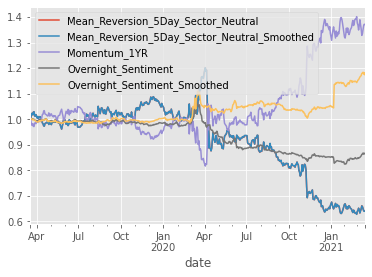

In [48]:
ls_factor_returns = pd.DataFrame()

for factor, factor_data in clean_factor_data.items():
    ls_factor_returns[factor] = al.performance.factor_returns(factor_data).iloc[:, 0]

(1+ls_factor_returns).cumprod().plot()

C:\Users\emota\anaconda3\envs\trading-dev\lib\site-packages\pandas\tools\plotting.py:3450: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\emota\anaconda3\envs\trading-dev\lib\site-packages\pandas\tools\plotting.py:3450: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\emota\anaconda3\envs\trading-dev\lib\site-packages\pandas\tools\plotting.py:3450: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\emota\anaconda3\envs\trading-de

array([[<AxesSubplot:title={'center':'Mean_Reversion_5Day_Sector_Neutral'}, xlabel='factor_quantile'>,
        <AxesSubplot:title={'center':'Mean_Reversion_5Day_Sector_Neutral_Smoothed'}, xlabel='factor_quantile'>],
       [<AxesSubplot:title={'center':'Momentum_1YR'}, xlabel='factor_quantile'>,
        <AxesSubplot:title={'center':'Overnight_Sentiment'}, xlabel='factor_quantile'>],
       [<AxesSubplot:title={'center':'Overnight_Sentiment_Smoothed'}, xlabel='factor_quantile'>,
        <AxesSubplot:xlabel='factor_quantile'>],
       [<AxesSubplot:xlabel='factor_quantile'>,
        <AxesSubplot:xlabel='factor_quantile'>]], dtype=object)

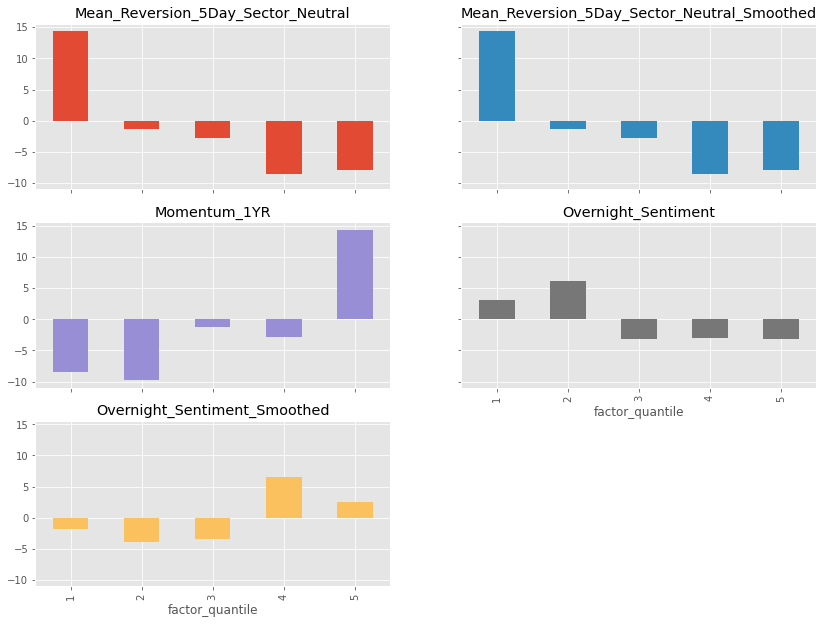

In [49]:
qr_factor_returns = pd.DataFrame()

for factor, factor_data in unixt_factor_data.items():
    qr_factor_returns[factor] = al.performance.mean_return_by_quantile(factor_data)[0].iloc[:, 0]

(10000*qr_factor_returns).plot.bar(
    subplots=True,
    sharey=True,
    layout=(4,2),
    figsize=(14, 14),
    legend=False)

<AxesSubplot:title={'center':'Factor Rank Autocorrelation'}, xlabel='date'>

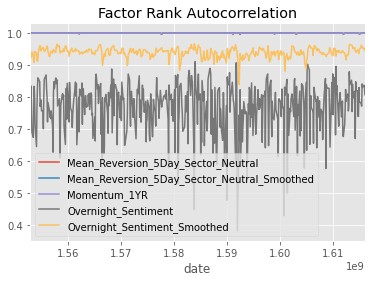

In [50]:
ls_FRA = pd.DataFrame()

for factor, factor_data in unixt_factor_data.items():
    ls_FRA[factor] = al.performance.factor_rank_autocorrelation(factor_data)

ls_FRA.plot(title="Factor Rank Autocorrelation")

In [51]:
def sharpe_ratio(factor_returns, annualization_factor):
    """
    Get the sharpe ratio for each factor for the entire period

    Parameters
    ----------
    factor_returns : DataFrame
        Factor returns for each factor and date
    annualization_factor: float
        Annualization Factor

    Returns
    -------
    sharpe_ratio : Pandas Series of floats
        Sharpe ratio
    """
    
    sharpe = data=annualization_factor*factor_returns.mean()/factor_returns.std()
    return sharpe

In [52]:
daily_annualization_factor = np.sqrt(252)
sharpe_ratio(ls_factor_returns, daily_annualization_factor).round(2)

Mean_Reversion_5Day_Sector_Neutral            -0.68
Mean_Reversion_5Day_Sector_Neutral_Smoothed   -0.68
Momentum_1YR                                   0.71
Overnight_Sentiment                           -0.92
Overnight_Sentiment_Smoothed                   0.86
dtype: float64

In [53]:
selected_factors = all_factors.columns[[1, 2, 4]]
print('Selected Factors: {}'.format(', '.join(selected_factors)))

all_factors['alpha_vector'] = all_factors[selected_factors].mean(axis=1)
alphas = all_factors[['alpha_vector']]
alpha_vector = alphas.loc[all_factors.index.get_level_values(0)[-1]]
alpha_vector.head()

Selected Factors: Mean_Reversion_5Day_Sector_Neutral_Smoothed, Momentum_1YR, Overnight_Sentiment_Smoothed


,alpha_vector
asset,
Equity(1 [AAV.TO]),-0.133025
Equity(2 [ABST.TO]),0.496599
Equity(3 [ABX.TO]),0.190760
Equity(4 [AC.TO]),0.314032
Equity(5 [ACB.TO]),0.395953


In [54]:
from abc import ABC, abstractmethod


class AbstractOptimalHoldings(ABC):    
    @abstractmethod
    def _get_obj(self, weights, alpha_vector):
        """
        Get the objective function

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        alpha_vector : DataFrame
            Alpha vector

        Returns
        -------
        objective : CVXPY Objective
            Objective function
        """
        
        raise NotImplementedError()
    
    @abstractmethod
    def _get_constraints(self, weights, factor_betas, risk):
        """
        Get the constraints

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        factor_betas : 2 dimensional Ndarray
            Factor betas
        risk: CVXPY Atom
            Predicted variance of the portfolio returns

        Returns
        -------
        constraints : List of CVXPY Constraint
            Constraints
        """
        
        raise NotImplementedError()
        
    def _get_risk(self, weights, factor_betas, alpha_vector_index, factor_cov_matrix, idiosyncratic_var_vector):
        f = factor_betas.loc[alpha_vector_index].values.T * weights
        X = factor_cov_matrix
        S = np.diag(idiosyncratic_var_vector.loc[alpha_vector_index].values.flatten())

        return cvx.quad_form(f, X) + cvx.quad_form(weights, S)
    
    def find(self, alpha_vector, factor_betas, factor_cov_matrix, idiosyncratic_var_vector):
        weights = cvx.Variable(len(alpha_vector))
        risk = self._get_risk(weights, factor_betas, alpha_vector.index, factor_cov_matrix, idiosyncratic_var_vector)
        
        obj = self._get_obj(weights, alpha_vector)
        constraints = self._get_constraints(weights, factor_betas.loc[alpha_vector.index].values, risk)
        
        prob = cvx.Problem(obj, constraints)
        prob.solve(max_iters=500)

        optimal_weights = np.asarray(weights.value).flatten()
        
        return pd.DataFrame(data=optimal_weights, index=alpha_vector.index)

In [55]:
class OptimalHoldings(AbstractOptimalHoldings):
    def _get_obj(self, weights, alpha_vector):
        """
        Get the objective function

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        alpha_vector : DataFrame
            Alpha vector

        Returns
        -------
        objective : CVXPY Objective
            Objective function
        """
        assert(len(alpha_vector.columns) == 1)

        obj = cvx.Minimize(
                -alpha_vector.values.flatten()*weights
            )
        return obj
    
    def _get_constraints(self, weights, factor_betas, risk):
        """
        Get the constraints

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        factor_betas : 2 dimensional Ndarray
            Factor betas
        risk: CVXPY Atom
            Predicted variance of the portfolio returns

        Returns
        -------
        constraints : List of CVXPY Constraint
            Constraints
        """
        assert(len(factor_betas.shape) == 2)
        
        constraints = [
            risk <= self.risk_cap**2,
            factor_betas.T * weights <= self.factor_max,
            factor_betas.T * weights >= self.factor_min,
            sum(weights) == 0.0,
            sum(cvx.abs(weights)) <= 1,
            weights >= self.weights_min,
            weights <= self.weights_max
        ]
        
        return constraints

    def __init__(self, risk_cap=0.05, factor_max=10.0, factor_min=-10.0, weights_max=0.55, weights_min=-0.55):
        self.risk_cap=risk_cap
        self.factor_max=factor_max
        self.factor_min=factor_min
        self.weights_max=weights_max
        self.weights_min=weights_min


In [ ]:
optimal_weights = OptimalHoldings().find(alpha_vector, risk_model['factor_betas'], risk_model['factor_cov_matrix'], risk_model['idiosyncratic_var_vector'])

optimal_weights.plot.bar(legend=None, title='Portfolio % Holdings by Stock')
x_axis = plt.axes().get_xaxis()
x_axis.set_visible(False)

In [ ]:
class OptimalHoldingsRegualization(OptimalHoldings):
    def _get_obj(self, weights, alpha_vector):
        """
        Get the objective function

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        alpha_vector : DataFrame
            Alpha vector

        Returns
        -------
        objective : CVXPY Objective
            Objective function
        """
        assert(len(alpha_vector.columns) == 1)
        
        obj = cvx.Minimize(
                -alpha_vector.values.T * weights + (self.lambda_reg * cvx.norm(weights, 2))
            )
        
        return obj

    def __init__(self, lambda_reg=0.5, risk_cap=0.05, factor_max=10.0, factor_min=-10.0, weights_max=0.55, weights_min=-0.55):
        self.lambda_reg = lambda_reg
        self.risk_cap=risk_cap
        self.factor_max=factor_max
        self.factor_min=factor_min
        self.weights_max=weights_max
        self.weights_min=weights_min

In [ ]:
optimal_weights_1 = OptimalHoldingsRegualization(lambda_reg=5.0).find(alpha_vector, risk_model['factor_betas'], risk_model['factor_cov_matrix'], risk_model['idiosyncratic_var_vector'])

optimal_weights_1.plot.bar(legend=None, title='Portfolio % Holdings by Stock')
x_axis = plt.axes().get_xaxis()
x_axis.set_visible(False)

In [ ]:
class OptimalHoldingsStrictFactor(OptimalHoldings):
    def _get_obj(self, weights, alpha_vector):
        """
        Get the objective function

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        alpha_vector : DataFrame
            Alpha vector

        Returns
        -------
        objective : CVXPY Objective
            Objective function
        """
        assert(len(alpha_vector.columns) == 1)
        
        alpha = alpha_vector.values[:,0]
        
        x =( alpha-np.mean(alpha))/sum(abs(alpha))
        
        obj = cvx.Minimize(
                cvx.pnorm(weights-x,2)
            )
        
        return obj

In [ ]:
optimal_weights_2 = OptimalHoldingsStrictFactor(
    weights_max=0.02,
    weights_min=-0.02,
    risk_cap=0.0015,
    factor_max=0.015,
    factor_min=-0.015).find(alpha_vector, risk_model['factor_betas'], risk_model['factor_cov_matrix'], risk_model['idiosyncratic_var_vector'])

optimal_weights_2.plot.bar(legend=None, title='Portfolio % Holdings by Stock')
x_axis = plt.axes().get_xaxis()
x_axis.set_visible(False)